In [1]:
import sys
import os
myDir = os.getcwd()
parentDir = os.path.abspath(os.path.join(myDir, os.pardir))
sys.path.append(parentDir)

from pathlib import Path
path = Path(parentDir)
a=str(path.parent.absolute())

sys.path.append(a)

In [2]:
from MetaX.utils.taxaFuncAnalyzer import TaxaFuncAnalyzer


In [3]:
df_path = './example_data/SW_TaxaFunc.tsv'
meta_path = './example_data/SW_Meta.tsv'
sw = TaxaFuncAnalyzer(df_path, meta_path)

original df shape: (3999, 229)
after remove all zero row: (3999, 229)


In [4]:
sw.set_func('Description')
sw.set_multi_tables(level='s')
# sw.set_multi_tables(level='s', transform_method = 'log2')

sw.set_group('Sweetener')

batch_list is not set, Batch effect removal did not perform.
transform_method is not set, data transform did not perform.
normalize_method is not set, data normalization did not perform.
Original data shape: (3999, 229)
Starting to set Function table...
Function number: 830
Starting to set Taxa table...
Taxa number: 340
Taxa-Function number: 1272
group is set to Sweetener
 {'KES', 'PBS', 'MFE', 'NDC', 'MAN', 'ADV', 'GLU', 'REB', 'ACE005', 'THA2', 'HSH', 'SOR', 'SUC', 'THA03', 'LAC', 'ACE2', 'SAA', 'STE', 'FOS', 'NEO2', 'ASP', 'ERY', 'SAC2', 'XYL', 'SAC05', 'MAL', 'ISO', 'NEO006', 'BAS', 'CYC'}


In [9]:
set(sw.group_list)

{'ACE005',
 'ACE2',
 'ADV',
 'ASP',
 'BAS',
 'CYC',
 'ERY',
 'FOS',
 'GLU',
 'HSH',
 'ISO',
 'KES',
 'LAC',
 'MAL',
 'MAN',
 'MFE',
 'NDC',
 'NEO006',
 'NEO2',
 'PBS',
 'REB',
 'SAA',
 'SAC05',
 'SAC2',
 'SOR',
 'STE',
 'SUC',
 'THA03',
 'THA2',
 'XYL'}

In [6]:
sw.meta_df[sw.meta_name].unique()

array(['PBS', 'ISO', 'SOR', 'ERY', 'HSH', 'MAN', 'SAC2', 'SAA', 'SAC05',
       'NEO2', 'FOS', 'MFE', 'KES', 'ACE005', 'SUC', 'GLU', 'NDC', 'BAS',
       'THA2', 'THA03', 'REB', 'CYC', 'ADV', 'XYL', 'STE', 'LAC', 'MAL',
       'ACE2', 'ASP', 'NEO006'], dtype=object)

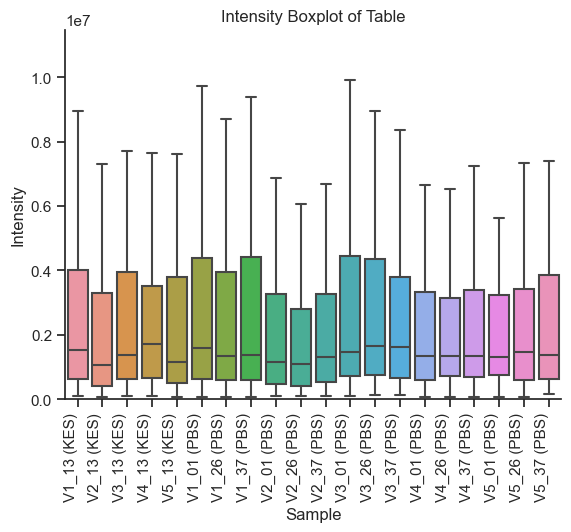

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class BasicPlot:
    def __init__(self, tfobj):
        self.tfobj =  tfobj
    # input: self.get_stats_peptide_num_in_taxa()
    # boxplot
    def plot_box_sns(self, df, table_name = 'Table', show_label = True, group_list = None):
        meta_df = self.tfobj.meta_df.copy()
        if group_list is not None:
            meta_df = meta_df[meta_df[self.tfobj.meta_name].isin(group_list)]

        SAMPLE_LIST = meta_df['Sample']
        GROUP_LIST = meta_df[self.tfobj.meta_name]
        new_sample_name = [
            f'{SAMPLE_LIST.iloc[i]} ({GROUP_LIST.iloc[i]})'
            for i in range(len(SAMPLE_LIST))
        ]

        # Order the SAMPLE_LIST and GROUP_LIST according to the group order
        group_order = sorted(list(set(GROUP_LIST)))
        ordered_sample_list = []
        ordered_sample_name = []
        for group in group_order:
            samples_in_group = [sample for sample, group_sample in zip(SAMPLE_LIST, GROUP_LIST) if group_sample == group]
            sample_names_in_group = [sample_name for sample_name, group_sample in zip(new_sample_name, GROUP_LIST) if group_sample == group]
            ordered_sample_list.extend(samples_in_group)
            ordered_sample_name.extend(sample_names_in_group)

        # Reorder the dataframe according to the new sample list order
        dft = df[ordered_sample_list]

        # replace 0 to NaN
        dft = dft.replace(0, np.nan)

        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)


        ax = sns.boxplot(data=dft, showfliers=False)
        # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
        ax.set_xticklabels(ordered_sample_name, rotation=90, horizontalalignment='right')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Intensity')
        ax.set_title(f'Intensity Boxplot of {table_name}')
        # set y limit as the 4th quantile of average peptide number
        ylimit = np.quantile(dft.mean(), 0.75) * 2
        ax.set_ylim(0, ylimit)
        plt.show()
        plt.close()
        return ax
fig = BasicPlot(sw).plot_box_sns(df = sw.taxa_df, group_list= ['KES', 'PBS'])

In [6]:
sw.taxa_df

,V1_01,V1_02,V1_03,V1_04,V1_05,V1_06,V1_07,V1_08,V1_09,V1_10,...,V5_29,V5_30,V5_31,V5_32,V5_33,V5_34,V5_35,V5_36,V5_37,V5_38
Taxon,,,,,,,,,,,,,,,,,,,,,
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium adolescentis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium breve,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium infantis,1037814,580417,1199873,592779,1921826,473415,0,763330,832110,778045,...,2725270,1884194,2448213,1971572,4471248,425820,303871,1749583,4044545,239669
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum,3320249,3195393,3514170,4277385,3837359,1864044,2802231,3456020,2398460,1879147,...,0,2449732,903497,11902,1598319,2276211,1492873,1287703,3339219,2391731
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium ruminantium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Morganella|s__Morganella morganii_A,0,0,0,910962,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Serratia|s__Serratia ureilytica,0,0,0,0,1041243,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Succinivibrionaceae|g__Anaerobiospirillum|s__Anaerobiospirillum sp900543125,0,0,0,0,0,0,0,5728667,0,0,...,0,0,0,0,0,0,0,0,0,0
